In [1]:
import keras
import pandas as pd
import numpy as np 
import matplotlib as plt

/home/max/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#no leasing.. requires some feature engineering
#data = pd.read_excel('/Volumes/Library/Download Bin/resd_data.xlsx')
data = pd.read_excel('/home/max/resd_data.xlsx')
data = data.fillna(0)
data = data[data.ListPrice >= 50000]
data = data[data.ListPrice <= 5000000]

#filtered Dataset where Year is missing
data = data[data.YearBuilt != 0]

#filtered dataset where NO zeros exist whatsoever!
#NoZeros = data.loc[~(data==0).any(axis=1)]

#Fix the index because ROWS were dropped
data = data.reset_index(drop=True)
total_label = np.array([data.ListPrice])


#slicing 
#total_input = np.array([[data.SquareFootageStructure],[data.LotSquareFootage],[data.YearBuilt],[data.Bedrooms],[data.BathsTotal],[data.field_StoriesTotal],[data.field_PostalCode]])
#------ postal removed---- ,[data.field_PostalCode]
#total_input = np.array([[data.SquareFootageStructure],[data.LotSquareFootage],[data.YearBuilt],[data.Bedrooms],[data.BathsTotal],[data.field_StoriesTotal]])
#------ postal removed---- ,[data.field_PostalCode]
#------ LotSqFoot removed----[data.LotSquareFootage],
total_input = np.array([[data.SquareFootageStructure],[data.YearBuilt],[data.Bedrooms],[data.BathsTotal],[data.field_StoriesTotal]])
total_label = np.array([data.ListPrice])

#Dimension resizing
END = len(np.transpose(total_input))
total_input = total_input[:,0,0:END]
total_input = total_input[:,0:END]
total_label = total_label[:,0:END]

#dicing                 #Here is where you specify your reserved test data
END_IN = END - 1000                    
train_input = total_input[:,0:END_IN]
train_label = total_label[:,0:END_IN]
test_input = total_input[:,END_IN:END]
test_label = total_label[:,END_IN:END]

#rotation
train_data = np.transpose(train_input)
train_targets = np.transpose(train_label)
test_data = np.transpose(test_input)
test_targets = np.transpose(test_label)

#normalization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(train_data)
scaler1 = StandardScaler().fit(train_targets)
scaler2 = StandardScaler().fit(test_data)
scaler3 = StandardScaler().fit(test_targets)

train_input = scaler.transform(train_data)
train_label = scaler1.transform(train_targets)
test_input = scaler2.transform(test_data)

from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(128, activation='relu',
                            input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(128, activation='relu'))
#    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
#    keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
    keras.optimizers.RMSprop(lr=0.001)
    return model

In [3]:
k=6
num_val_samples = len(train_data) // k
num_epochs = 500
all_scores = []
all_mae_histories = []

for i in range(k):
    print('processing fold #', i)
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] 
    
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    
    partial_train_data = np.concatenate( [train_data[:i * num_val_samples],
    train_data[(i + 1) * num_val_samples:]], axis=0)
    
    partial_train_targets = np.concatenate( [train_targets[:i * num_val_samples],
    train_targets[(i + 1) * num_val_samples:]], axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
              validation_data=(val_data, val_targets),
              epochs=num_epochs, batch_size=1024, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
processing fold # 5


# Visualize how the score changes by epoch

In [4]:
import matplotlib.pyplot as plt
import matplotlib.axes as axes


all_scores
average_mae_history = [
    np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]
plt.plot(average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')

plt.show()

<Figure size 640x480 with 1 Axes>

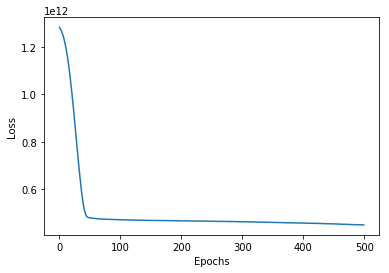

In [5]:
import matplotlib.pyplot as plt
import matplotlib.axes as axes
#plt.plot(average_mae_history)
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

# Compare test and training data visually
## Select a slice of both the input data and the input label
## Create a prediction vector using the stored model
## Plot the prediction model with the input labels
## The closer the lines overlap, the better the prediction 

(999, 1)
(1000, 1)


(0, 5241800.0)

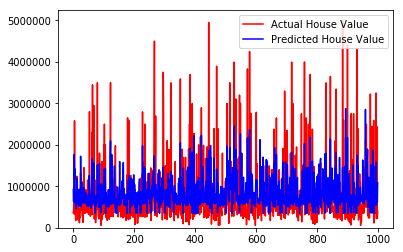

In [6]:
#Selected Range Input
A = 1
B = 1000
y_pred_all = model.predict(test_data)
# y_pred_all = scaler3.inverse_transform(y_pred_all.transpose()).transpose()
y_pred_all = (y_pred_all.transpose()).transpose()
y_pred_norm = y_pred_all[A:B,:]

print(y_pred_norm.shape)
print(test_targets.shape)
y_act_all = test_targets
y_act_norm = test_targets[A:B,:]

plt.plot(y_act_norm,'r',label='Actual House Value')
plt.plot(y_pred_norm,'b',label='Predicted House Value')
plt.legend()
plt.ylim(bottom=0)



# Observe entire prediction of test data

(0.0, 5000000.0)

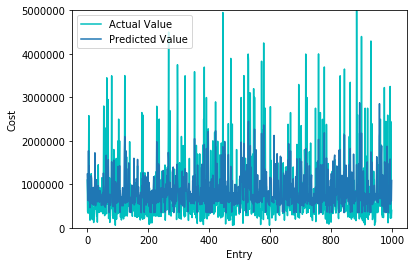

In [7]:
plt.plot(y_act_all[:,:],'c',label='Actual Value')
plt.plot(y_pred_all[:,:],label='Predicted Value')
plt.xlabel('Entry')
plt.ylabel('Cost')
plt.legend()
plt.ylim(bottom=0)
plt.ylim(top=5e6)

In [8]:
import sklearn.metrics
print(np.mean(y_pred_all))
print(np.mean(y_act_all))
sklearn.metrics.mean_absolute_error(y_pred_all,y_act_all)

851234.56
841683.745


430954.214

In [9]:
#np.argwhere(y_label <= 50000)